In [1]:
# You may need to install htmllib5,lxml, and BeautifulSoup4. In your terminal/command prompt run:

# conda install lxml
# conda install html5lib
# conda install BeautifulSoup4
# Then restart Jupyter Notebook. (or use pip install if you aren't using the Anaconda Distribution)

import numpy as np
import pandas as pd
import os.path
from datetime import datetime, timedelta

one_hour_ago = datetime.now() - timedelta(hours=1)
if os.path.exists("history.csv"):
    filetime = datetime.fromtimestamp(os.path.getctime("history.csv"))
    if filetime < one_hour_ago:
        histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
        histdata[0].to_csv('history.csv',index=False)
else:
    histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
    histdata[0].to_csv('history.csv',index=False)

df = pd.read_csv('history.csv').set_index('Ticker')
df.index.name=None

df[["Date","Catalyst"]] = df.Catalyst.str.extract('(?P<Date>[0-9]{2}\/[0-9]{2}\/[0-9]{4})(?P<Catalyst>.*)', expand=True)

df.loc["OCUL"]


,Drug,Stage,Catalyst,Date
OCUL,DEXTENZA Allergic conjunctivitis,Phase 3,Phase 3 trial did not meet primary endpoint ...,06/06/2016
OCUL,DEXTENZA Ocular inflammation and pain followi...,Approved,CRL July 25 2016 - due to manufacturing defi...,07/25/2016
OCUL,DEXTENZA Ocular inflammation and pain followi...,Approved,CRL July 25 2016 - due to manufacturing defi...,07/11/2017
OCUL,DEXTENZA Ocular inflammation and pain followi...,Approved,"FDA approval announced December 3, 2018.",12/03/2018


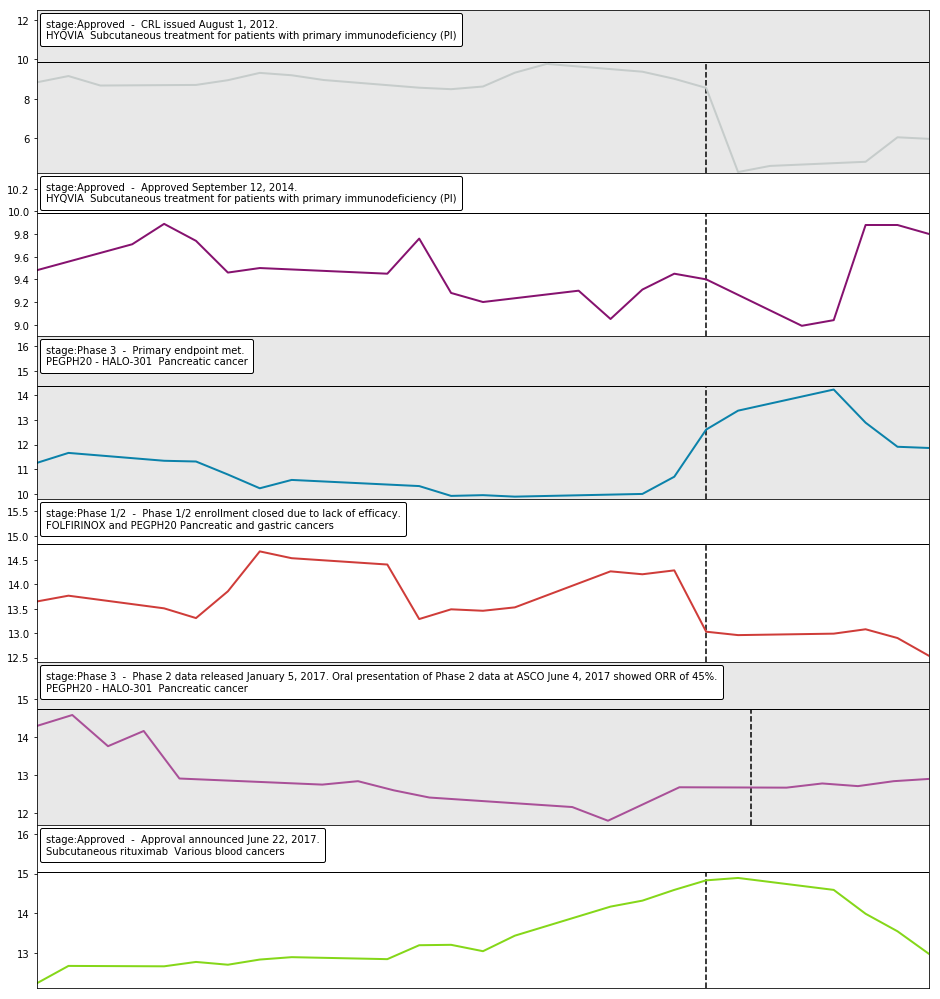

In [469]:
# You may need to install htmllib5,lxml, and BeautifulSoup4. In your terminal/command prompt run:

# conda install lxml
# conda install html5lib
# conda install BeautifulSoup4
# Then restart Jupyter Notebook. (or use pip install if you aren't using the Anaconda Distribution)
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import *
from pylab import text
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import quandl


# Quandl API key
quandl.ApiConfig.api_key = "UsYsv7dKGxHHQ5oURP4B"

# Some formatting
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_seq_items', 2)

# Only pull fresh PDUFA data
three_weeks_ago = relativedelta(weeks=3)
one_week_ahead = relativedelta(weeks=1)
one_hour_ago = datetime.now() - timedelta(hours=1)
if os.path.exists("history.csv"):
    filetime = datetime.fromtimestamp(os.path.getctime("history.csv"))
    if filetime < one_hour_ago:
        histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
        histdata[0].to_csv('history.csv',index=False)
else:
    histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
    histdata[0].to_csv('history.csv',index=False)

# Create dataframe
df = pd.read_csv('history.csv').set_index('Ticker')
df.index.name=None
df[["Date","Catalyst"]] = df.Catalyst.str.extract('(?P<Date>[0-9]{2}\/[0-9]{2}\/[0-9]{4})(?P<Catalyst>.*)', expand=True)
df['Date'] = pd.to_datetime(df['Date'])
df["Past"] = df["Date"] - DateOffset(weeks=3)
df["Future"] = df["Date"] + DateOffset(weeks=1)

df
# Set stock ticker
stockpick="HALO"
dataset=str(f"WIKI/{stockpick}")
# Set variables for plot creation
length = len(df.loc[stockpick].index)
count = 0
fig, axes = plt.subplots(nrows=length, ncols=1,figsize=(16,length * 3))
fig.subplots_adjust(hspace=0, wspace=0)
allplots=[]

# Combine all data together into list of dataframes, iterate through each part of the list, plot each frame.
while (count < length):
    pasttime= df.loc[stockpick].iloc[count]["Past"]
    futuretime= df.loc[stockpick].iloc[count]["Future"]
    pdufa=df.loc[stockpick].iloc[count]["Date"]
    annotate = df.loc[stockpick].iloc[count]["Date"] + timedelta(days=1)
    stage = df.loc[stockpick].iloc[count]["Stage"]
    catalyst = df.loc[stockpick].iloc[count]["Catalyst"]
    drug = df.loc[stockpick].iloc[count]["Drug"]
    
    #Annotation
    tooltip = f"stage:{stage}  -{catalyst}\n{drug}"
    at = AnchoredText(tooltip,
                      prop=dict(size=10), frameon=True,
                      loc=2, 
                      )
    at.patch.set_boxstyle("round,pad=0.2,rounding_size=0.2")
    axes[count].add_artist(at)
    axes[count].margins(0.0, 0.5)
    #Get quandl data
    mydata = quandl.get(dataset,start_date=pasttime,end_date=futuretime)
    allplots.append(mydata)
#     axes[count].annotate('local max', xy=(pdufa, allplots[count]["Close"].max()), xytext=(annotate, (allplots[count]["Close"].max() - allplots[count]["Close"].min()) * 0.9 + allplots[count]["Close"].min()),
#             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),)
    # Set y limit for notes
    axes[count].set_ylim(allplots[count]["Close"].min() * .99 , (allplots[count]["Close"].max()-allplots[count]["Close"].min()) * 0.5 + allplots[count]["Close"].max())
    axes[count].hlines(allplots[count]["Close"].max() * 1.01, allplots[count].head(1).index, allplots[count].tail(1).index, linestyle="-", lw=1, color='black')
    if count % 2 == 0:
        axes[count].set_facecolor((0.91, 0.91, 0.91))  

    axes[count].vlines(pdufa, allplots[count]["Close"].min() * .99, allplots[count]["Close"].max() * 1.01, linestyle="--", color='black')
    axes[count].plot(allplots[count].index,allplots[count]["Close"],c=np.random.rand(3,), lw=2, label=pdufa) 
    axes[count].axes.get_xaxis().set_visible(False) # remove x axis
    count = count + 1
plt.show()

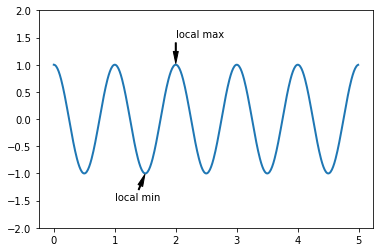

In [2]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

t = np.arange(0.0, 5.0, 0.01)
s = np.cos(2*np.pi*t)
line, = ax.plot(t, s, lw=2)

ax.annotate('local max', xy=(2, 1), xytext=(2, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
            )

ax.annotate('local min', xy=(1.5, -1), xytext=(1, -1.5),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
            )

ax.set_ylim(-2,2)
plt.show()

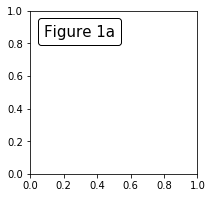

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

fig=plt.figure(1, figsize=(3,3))
ax = plt.subplot(111)

at = AnchoredText("Figure 1a",
                  prop=dict(size=15), frameon=True,
                  loc=2, 
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)

plt.show()

In [48]:
# conda install BeautifulSoup4
# Then restart Jupyter Notebook. (or use pip install if you aren't using the Anaconda Distribution)
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import *
from pylab import text
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import quandl


# Quandl API key
quandl.ApiConfig.api_key = "UsYsv7dKGxHHQ5oURP4B"

# Some formatting
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_seq_items', 2)

# Only pull fresh PDUFA data
three_weeks_ago = relativedelta(weeks=3)
one_week_ahead = relativedelta(weeks=1)
one_hour_ago = datetime.now() - timedelta(hours=1)
if os.path.exists("history.csv"):
    filetime = datetime.fromtimestamp(os.path.getctime("history.csv"))
    if filetime < one_hour_ago:
        histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
        histdata[0].to_csv('history.csv',index=False)
else:
    histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
    histdata[0].to_csv('history.csv',index=False)

# Create dataframe
df = pd.read_csv('history.csv').set_index('Ticker')
df.index.name=None
df[["Date","Catalyst"]] = df.Catalyst.str.extract('(?P<Date>[0-9]{2}\/[0-9]{2}\/[0-9]{4})(?P<Catalyst>.*)', expand=True)
df['Date'] = pd.to_datetime(df['Date'])
df["Past"] = df["Date"] - DateOffset(weeks=3)
df["Future"] = df["Date"] + DateOffset(weeks=1)

df


,Drug,Stage,Catalyst,Date,Past,Future
SPPI,ZEVALIN Non-Hodgkin’s lymphoma,CRL,"CRL received July 5, 2009.",2009-07-05,2009-06-14,2009-07-12
ZGNX,Sumavel Migraine,Approved,"Approved July 16, 2009.",2009-07-16,2009-06-25,2009-07-23
ARDM,Sumavel Migraine,Approved,"Approval granted July 16, 2009.",2009-07-16,2009-06-25,2009-07-23
SPPI,ZEVALIN Non-Hodgkin’s lymphoma,CRL,"Approved September 4, 2009.",2009-09-04,2009-08-14,2009-09-11
SPPI,FUSILEV Colorectal cancer,Approved,"CRL received October 9, 2009.",2009-10-09,2009-09-18,2009-10-16
PRTK,Intermezzo Insomnia,Approved,"CRL issued November 2, 2009.",2009-11-02,2009-10-12,2009-11-09
GTXI,Toremifene Reduce fractures in men with prostate cancer,CRL,"CRL issued November 2, 2009.",2009-11-02,2009-10-12,2009-11-09
HEB,Ampligen CFS,CRL,"CRL issued December 1, 2009.",2009-12-01,2009-11-10,2009-12-08
FCSC,Laviv Wrinkles,Approved,"CRL issued December 18, 2009.",2009-12-18,2009-11-27,2009-12-25
ACOR,Ampyra Improve walking in patients with multiple sclerosis,-,"Approved January 22, 2010.",2010-01-22,2010-01-01,2010-01-29


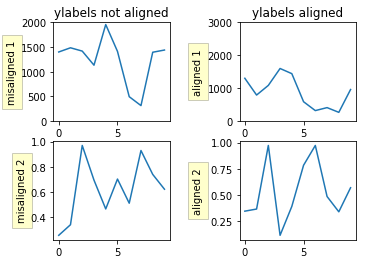

In [419]:
import numpy as np
import matplotlib.pyplot as plt


def make_plot(axs):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    # Fixing random state for reproducibility
    np.random.seed(19680801)
    ax1 = axs[0, 0]
    ax1.plot(2000*np.random.rand(10))
    ax1.set_title('ylabels not aligned')
    ax1.set_ylabel('misaligned 1', bbox=box)
    ax1.set_ylim(0, 2000)

    ax3 = axs[1, 0]
    ax3.set_ylabel('misaligned 2', bbox=box)
    ax3.plot(np.random.rand(10))

    ax2 = axs[0, 1]
    ax2.set_title('ylabels aligned')
    ax2.plot(2000*np.random.rand(10))
    ax2.set_ylabel('aligned 1', bbox=box)
    ax2.set_ylim(0, 3000)

    ax4 = axs[1, 1]
    ax4.plot(np.random.rand(10))
    ax4.set_ylabel('aligned 2', bbox=box)


# Plot 1:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs)

# just align the last column of axes:
fig.align_ylabels(axs[:, 1])
plt.show()